<a href="https://colab.research.google.com/github/Bgilbe/NuclearCodes/blob/main/PCOS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
####Reactivate line in main code once out of CoLab
## Loading and file processing
# Load dataset
from google.colab import files
uploaded = files.upload()

Saving PCOS_data.csv to PCOS_data.csv


In [ ]:
# Import libraries
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from google.colab import files
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch


# Analytical functions

# CAP Evaluation
def plot_cap(y_test, rf_y_prob, model_type):
    # Sort scores and corresponding actual values
    sorted_indices = np.argsort(rf_y_prob)[::-1]
    y_test_sorted = np.array(y_test)[sorted_indices]
    # Compute gains
    total_positives = np.sum(y_test)
    x_values = np.linspace(0, 1, len(y_test))
    y_values = np.cumsum(y_test_sorted) / total_positives
    # Random classifier line
    random_line = np.linspace(0, 1, len(y_test))
    # Perfect model line
    perfect_x = [0, total_positives / len(y_test), 1]
    perfect_y = [0, 1, 1]
    # Plot CAP curve
    plt.figure(figsize=(6, 6))
    plt.plot(x_values, y_values, color='red', lw=2, label='Model CAP')
    plt.plot(x_values, random_line, color='green', linestyle='--', label='Random Model')
    plt.plot(perfect_x, perfect_y, color='blue', linestyle='-.', label='Perfect Model')
    plt.xlabel('Proportion of Sample')
    plt.ylabel('Proportion of Positives Captured')
    plt.title(f'Cumulative Accuracy Profile (CAP) Curve for {model_type}')
    plt.legend(loc='lower right')
    plt.show()

# ROC/AUC Evaluation
def plot_roc(y_test, y_prob, model_type):
    # Solve
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {roc_auc:.2f}")
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='gold', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_type}')
    plt.legend(loc="lower right")
    plt.show()

# function to print metrics
def metrics(y_test, y_pred, model_type):
    # Compute and display metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n===== {model_type} =====")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")


def train_evaluate(model, x_train, x_test, y_train, y_test, model_name):
    # training
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    # evaluations
    metrics(y_test, y_pred, model_name)
    return accuracy_score(y_test, y_pred)

def conf_matrix(y_test, y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

def elbow_method(data, feature_name):
    W = []  # Within-cluster variance
    N_itr = 20  # Maximum number of clusters to evaluate

    for k in range(1, N_itr):
        kmeans = KMeans(n_clusters=k, random_state=14, init="k-means++")
        kmeans.fit(data)
        W.append(kmeans.inertia_)

    # Plot Elbow Method results
    plt.plot(range(1, N_itr), W, marker="o")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title(f"Elbow Method for {feature_name}")
    plt.show()

In [ ]:
## Loading and file processing
# Load dataset
data = pd.read_csv("PCOS_data.csv")

# Convert all values to numeric, set errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the mean of each column
data = data.fillna(data.mean())

# Set features and target
x = data.drop(columns=['PCOS (Y/N)', 'Sl. No', 'Patient File No.']) # Drop serial and ID numbers not useful for prediction
y = data['PCOS (Y/N)']

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


===== Random Forest =====
Accuracy: 0.79
Precision: 0.70
Recall: 0.50
F1-score: 0.58
Random Forest (n_estimators=10) Accuracy: 0.7890

===== Random Forest =====
Accuracy: 0.86
Precision: 0.81
Recall: 0.69
F1-score: 0.75
Random Forest (n_estimators=15) Accuracy: 0.8624

===== Random Forest =====
Accuracy: 0.87
Precision: 0.85
Recall: 0.69
F1-score: 0.76
Random Forest (n_estimators=20) Accuracy: 0.8716

===== Random Forest =====
Accuracy: 0.87
Precision: 0.82
Recall: 0.72
F1-score: 0.77
Random Forest (n_estimators=25) Accuracy: 0.8716

===== Random Forest =====
Accuracy: 0.85
Precision: 0.81
Recall: 0.66
F1-score: 0.72
Random Forest (n_estimators=30) Accuracy: 0.8532

===== Random Forest =====
Accuracy: 0.84
Precision: 0.83
Recall: 0.59
F1-score: 0.69
Random Forest (n_estimators=50) Accuracy: 0.8440

===== Random Forest =====
Accuracy: 0.87
Precision: 0.91
Recall: 0.62
F1-score: 0.74
Random Forest (n_estimators=100) Accuracy: 0.8716

===== Random Forest =====
Accuracy: 0.86
Precision: 0

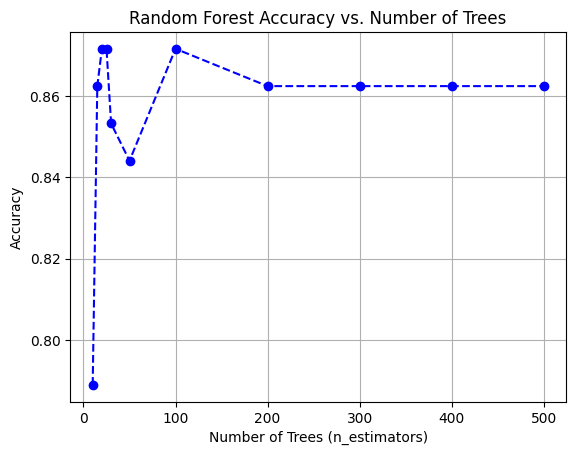


===== Random Forest =====
Accuracy: 0.92
Precision: 0.93
Recall: 0.78
F1-score: 0.85
AUC: 0.95


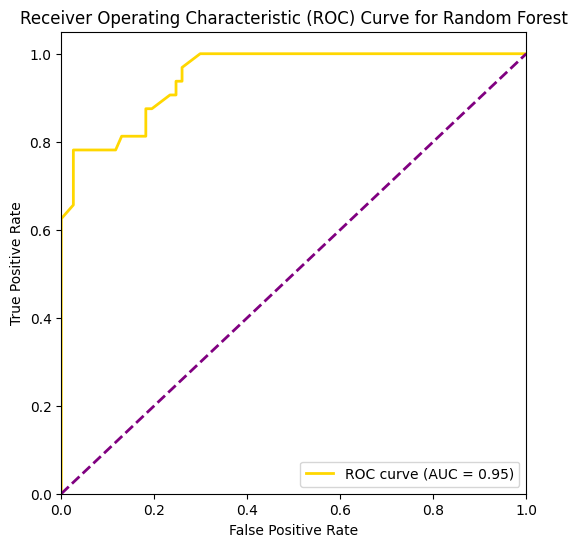

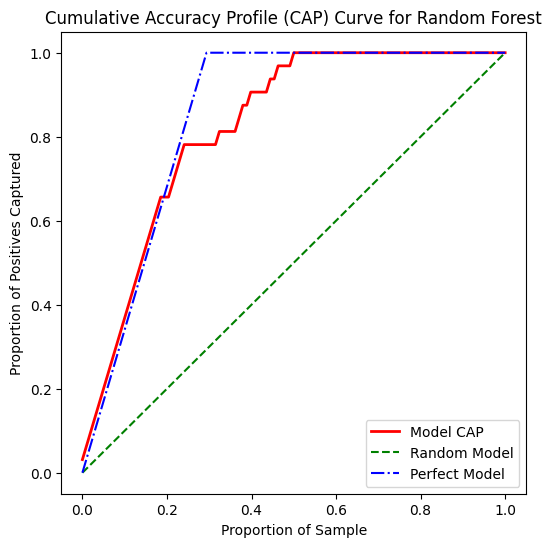

In [50]:
## Random Forest

# Train Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42).fit(x_train, y_train)
rf_y_pred = rf_classifier.predict(x_test)
rf_y_prob = rf_classifier.predict_proba(x_test)[:, 1]

n_estimators_list = [10, 15, 20, 25, 30, 50, 100, 200, 300, 400, 500]  # Relevant range for tuning
accuracy_scores = []

# Loop through different n_estimators and store accuracy
for n_estimators in n_estimators_list:
    rf_tuned = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    accuracy = train_evaluate(rf_tuned, x_train, x_test, y_train, y_test, "Random Forest")
    accuracy_scores.append(accuracy)
    print(f"Random Forest (n_estimators={n_estimators}) Accuracy: {accuracy:.4f}")

# Plot Accuracy Trend
plt.plot(n_estimators_list, accuracy_scores, marker="o", linestyle="--", color="b")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs. Number of Trees")
plt.grid()
plt.show()


# Calculate Metrics
metrics(y_test, rf_y_pred, 'Random Forest')

# Call the ROC function
plot_roc(y_test, rf_y_prob, 'Random Forest')

# Call the CAP function
plot_cap(y_test, rf_y_prob, 'Random Forest')


===== Decision Tree =====
Accuracy: 0.83
Precision: 0.71
Recall: 0.75
F1-score: 0.73

===== Decision Tree (max_depth=3, min_samples_split=2) =====
Accuracy: 0.79
Precision: 0.66
Recall: 0.59
F1-score: 0.62

===== Decision Tree (max_depth=3, min_samples_split=5) =====
Accuracy: 0.79
Precision: 0.66
Recall: 0.59
F1-score: 0.62

===== Decision Tree (max_depth=3, min_samples_split=10) =====
Accuracy: 0.79
Precision: 0.66
Recall: 0.59
F1-score: 0.62

===== Decision Tree (max_depth=5, min_samples_split=2) =====
Accuracy: 0.83
Precision: 0.69
Recall: 0.75
F1-score: 0.72

===== Decision Tree (max_depth=5, min_samples_split=5) =====
Accuracy: 0.82
Precision: 0.67
Recall: 0.75
F1-score: 0.71

===== Decision Tree (max_depth=5, min_samples_split=10) =====
Accuracy: 0.81
Precision: 0.65
Recall: 0.75
F1-score: 0.70

===== Decision Tree (max_depth=10, min_samples_split=2) =====
Accuracy: 0.83
Precision: 0.71
Recall: 0.75
F1-score: 0.73

===== Decision Tree (max_depth=10, min_samples_split=5) =====
A

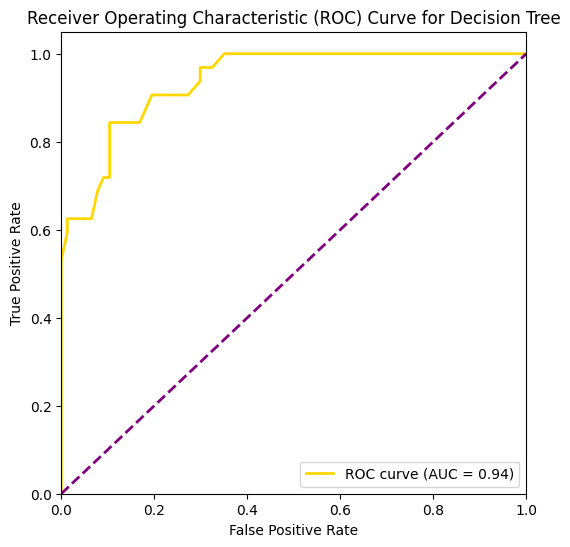

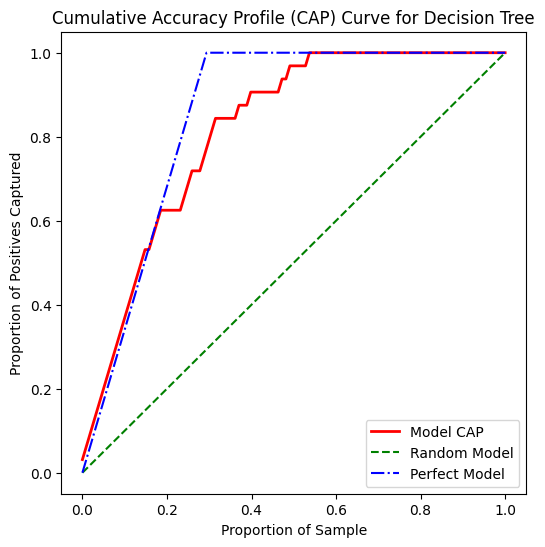

In [ ]:
## Decision Tree

# Train Decision Tree
dt_classifier = DecisionTreeClassifier(max_depth=100, min_samples_split=2, random_state=42)
train_evaluate(dt_classifier, x_train, x_test, y_train, y_test, 'Decision Tree')
dt_y_pred = rf_classifier.predict(x_test)
dt_y_prob = rf_classifier.predict_proba(x_test)[:, 1]

# Hyperparameter tuning for Decision Tree
for max_depth in [3, 5, 10]:
    for min_samples_split in [2, 5, 10]:
        dt_tuned = DecisionTreeClassifier(max_depth=max_depth,
                                          min_samples_split=min_samples_split, random_state=42)
        train_evaluate(dt_tuned, x_train, x_test, y_train, y_test, f"Decision Tree (max_depth={max_depth}, min_samples_split={min_samples_split})")

# Call the ROC function
plot_roc(y_test, dt_y_prob, 'Decision Tree')

# Call the CAP function
plot_cap(y_test, dt_y_prob, 'Decision Tree')


===== KNN =====
Accuracy: 0.66
Precision: 0.39
Recall: 0.28
F1-score: 0.33
AUC: 0.56


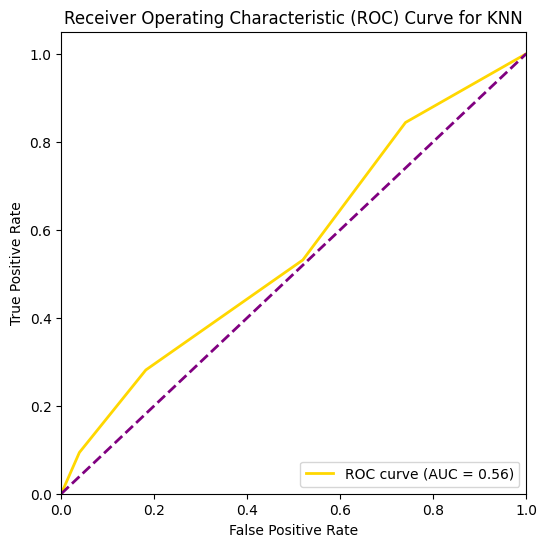

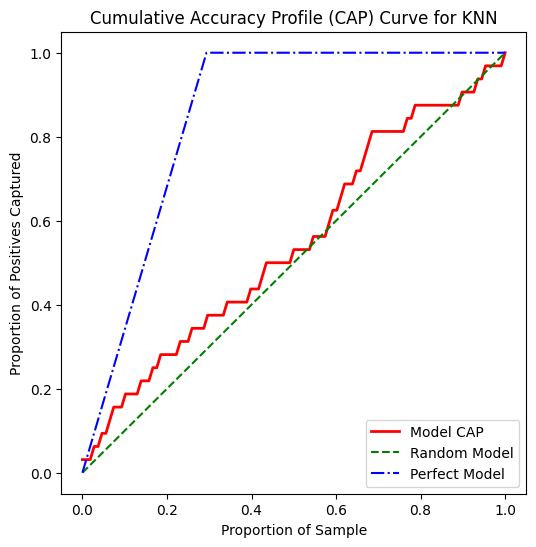

In [ ]:
## K-Nearest Neighbor

# KNN
knn = KNeighborsClassifier().fit(x_train, y_train)
knn_y_pred = knn.predict(x_test)
knn_y_prob = knn.predict_proba(x_test)[:, 1]

# Calculate Metrics
metrics(y_test, knn_y_pred, 'KNN')

# AUC
plot_roc(y_test, knn_y_prob, 'KNN')

# Call the CAP function
plot_cap(y_test, knn_y_prob, 'KNN')

In [ ]:
## Feature Selection MLR

def eval_method(features, method):
    model = LinearRegression()
    model.fit(x_train[features], y_train)
    y_MLR_pred = model.predict(x_test[features])

    r2 = r2_score(y_test, y_MLR_pred)
    mse = mean_squared_error(y_test, y_MLR_pred)

    print(f"\n=== {method} ===")
    print(f"Top 4 Features: {features[:4]}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

print("\n=====Multi Linear Regression=====")

# Full Model (All Features)
eval_method(x.columns.tolist(), "Full Model")

# 2. Backward Elimination
sfs = SFS(LinearRegression(), k_features=5, forward=False)
sfs.fit(x_train, y_train)
features_sfs = list(sfs.k_feature_names_)
eval_method(features_sfs, "Backward Elimination")

# 3. Forward Selection
sfs_fwd = SFS(LinearRegression(), k_features=5, forward=True)
sfs_fwd.fit(x_train, y_train)
features_sfs_fwd = list(sfs_fwd.k_feature_names_)
eval_method(features_sfs_fwd, "Forward Selection")

# 4. Bidirectional Elimination
sfs_bi = SFS(LinearRegression(), k_features=5, forward=True, floating=True,
          scoring='neg_mean_squared_error', cv=5)
sfs_bi.fit(x_train, y_train)
features_sfs_bi = list(sfs_bi.k_feature_names_)
eval_method(features_sfs_bi, "Bidirectional Elimination")

# 5. ANOVA F-test
anova_f = SelectKBest(score_func=f_regression, k=5)
anova_f.fit(x_train, y_train)
selected_features_anova = x.columns[anova_f.get_support()].tolist()
eval_method(selected_features_anova, "ANOVA F-test")

# 6. Mutual Information
mi = SelectKBest(score_func=mutual_info_regression, k=5)
mi.fit(x_train, y_train)
selected_features_mi = x.columns[mi.get_support()].tolist()
eval_method(selected_features_mi, "Mutual Information")

# 7. Pearson Correlation
correlations = {col: abs(pearsonr(x_train[col], y_train)[0]) for col in x_train.columns}
selected_features_corr = sorted(correlations, key=correlations.get, reverse=True)[:4]
eval_method(selected_features_corr, "Pearson Correlation")


=====Multi Linear Regression=====

=== Full Model ===
Top 4 Features: [' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'BMI']
R² Score: 0.4867
Mean Squared Error (MSE): 0.1065

=== Backward Elimination ===
Top 4 Features: ['Cycle(R/I)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)']
R² Score: 0.5854
Mean Squared Error (MSE): 0.0860

=== Forward Selection ===
Top 4 Features: ['Cycle(R/I)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)']
R² Score: 0.5854
Mean Squared Error (MSE): 0.0860

=== Bidirectional Elimination ===
Top 4 Features: ['Cycle(R/I)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)']
R² Score: 0.5854
Mean Squared Error (MSE): 0.0860

=== ANOVA F-test ===
Top 4 Features: ['Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Follicle No. (L)']
R² Score: 0.5683
Mean Squared Error (MSE): 0.0895

=== Mutual Information ===
Top 4 Features: ['Cycle(R/I)', 'Cycle length(days)', 'Skin darkening (Y/N)', 'Follicle No. (L)']
R²

<ipython-input-49-4eda125ef898>:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations = {col: abs(pearsonr(x_train[col], y_train)[0]) for col in x_train.columns}


Test set accuracy: 0.8348623853211009
Best hyperparameters found: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'sgd'}

Best cross-validation accuracy: 91.67%
Test set accuracy: 88.07%

===== MLP Classifier =====
Accuracy: 0.88
Precision: 0.91
Recall: 0.66
F1-score: 0.76
AUC: 0.94


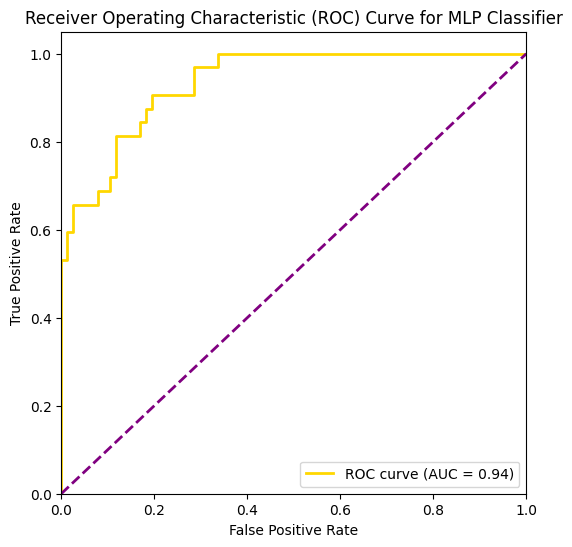

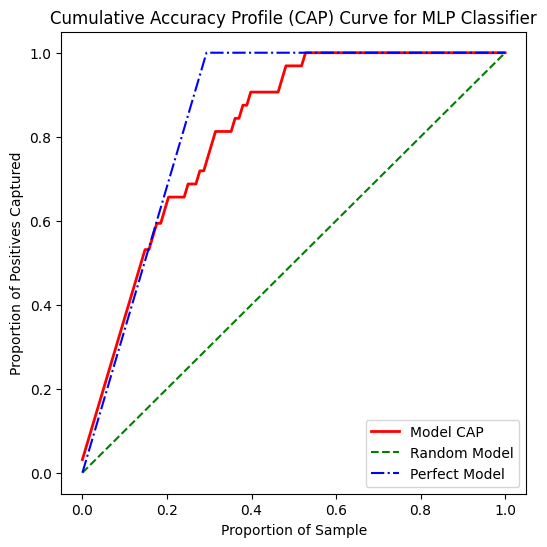

In [ ]:
## MLP

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=10)
mlp.fit(X_train, y_train)

# Evaluate the model
accuracy = mlp.score(X_test, y_test)
print("Test set accuracy:", accuracy)

# Hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],  # L2 regularization term
    'learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display best parameters
print("Best hyperparameters found:", grid_search.best_params_)
print("\nBest cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Evaluate best model
best_mlp = grid_search.best_estimator_
mlp_test_accuracy = best_mlp.score(X_test, y_test)
print("Test set accuracy: {:.2f}%".format(mlp_test_accuracy * 100))

# Calculate y_pred and y_prob using the best model
y_MLP_pred = best_mlp.predict(X_test)
y_MLP_prob = best_mlp.predict_proba(X_test)[:, 1]

metrics(y_test, y_MLP_pred, 'MLP Classifier')

# Call the ROC function
plot_roc(y_test, y_MLP_prob, 'MLP Classifier')

# Call the CAP function
plot_cap(y_test, y_MLP_prob, 'MLP Classifier')


===== Naive Bayes =====
Accuracy: 0.78
Precision: 0.59
Recall: 0.84
F1-score: 0.69
AUC: 0.84


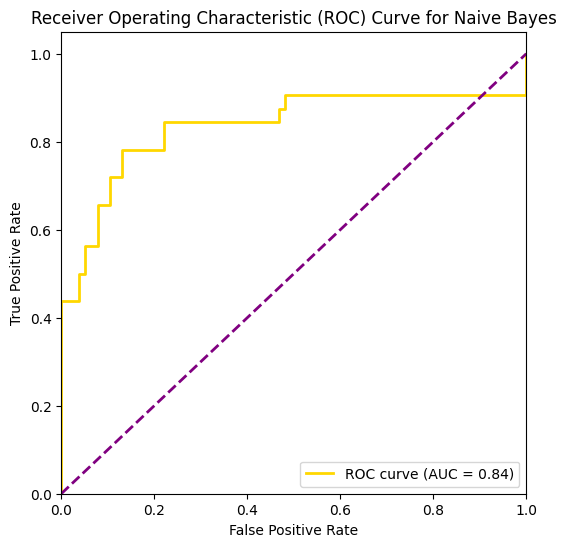

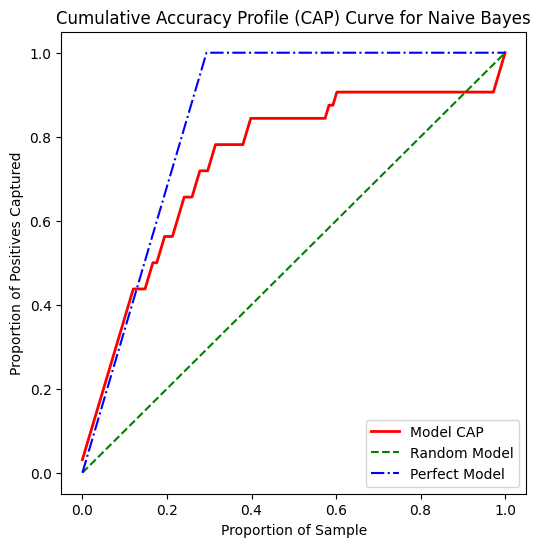

In [ ]:
## Naive Bayes

# Train and evaluate Naive Bayes
nb_classifier = GaussianNB()
train_evaluate(nb_classifier, x_train, x_test, y_train, y_test, "Naive Bayes")

# Predictions
nb_y_pred = nb_classifier.predict(x_test)
nb_y_prob = nb_classifier.predict_proba(x_test)[:, 1]

# ROC & CAP Evaluation
plot_roc(y_test, nb_y_prob, "Naive Bayes")
plot_cap(y_test, nb_y_prob, "Naive Bayes")


===== SVM =====
Accuracy: 0.84
Precision: 0.80
Recall: 0.62
F1-score: 0.70
AUC: 0.84


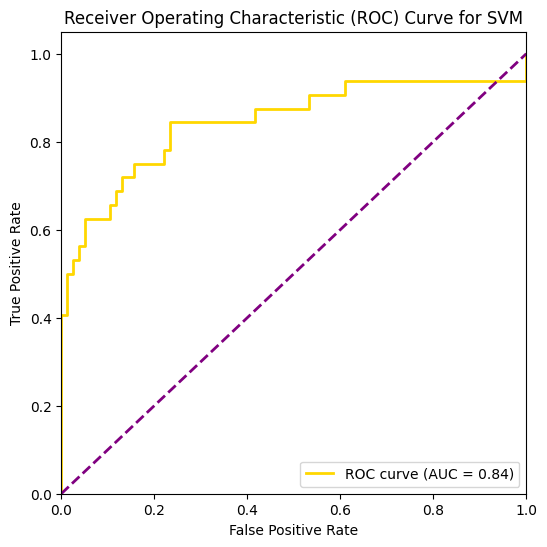

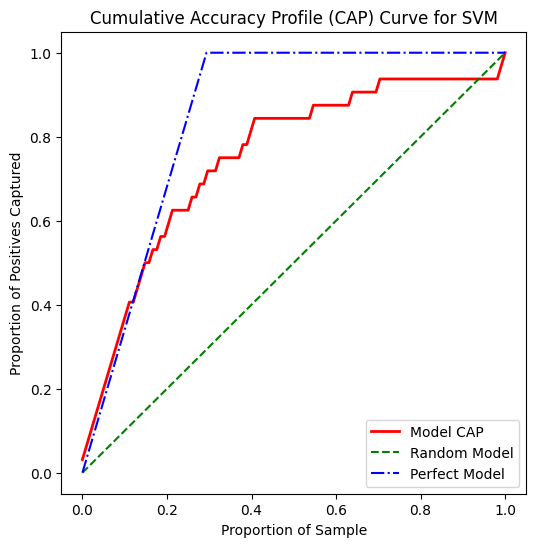

In [ ]:
## SVM

# Train and evaluate SVM
svm_classifier = SVC(kernel="linear", probability=True, random_state=42)
train_evaluate(svm_classifier, x_train, x_test, y_train, y_test, "SVM")

# Predictions
svm_y_pred = svm_classifier.predict(x_test)
svm_y_prob = svm_classifier.predict_proba(x_test)[:, 1]

# ROC & CAP Evaluation
plot_roc(y_test, svm_y_prob, "SVM")
plot_cap(y_test, svm_y_prob, "SVM")

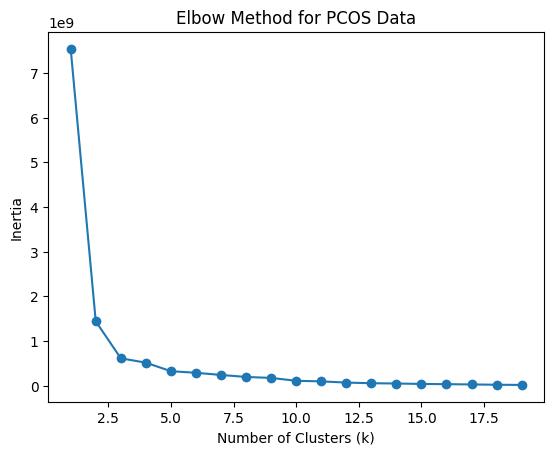

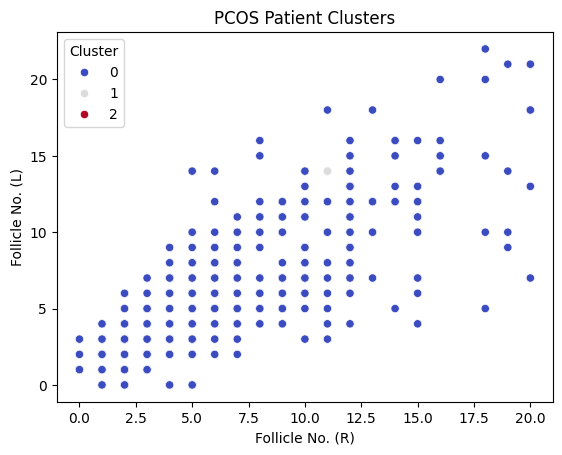

In [ ]:
## K-Means

# Determine optimal clusters using the elbow method
elbow_method(x, "PCOS Data")

# Run k-Means with optimal clusters (adjust based on elbow method results)
kmeans = KMeans(n_clusters=3, random_state=42, init="k-means++")
kmeans.fit(x)

# Add cluster labels to dataset
data["Cluster"] = kmeans.labels_

# Visualize clusters
sns.scatterplot(x=data["Follicle No. (R)"], y=data["Follicle No. (L)"], hue=data["Cluster"], palette="coolwarm")
plt.xlabel("Follicle No. (R)")
plt.ylabel("Follicle No. (L)")
plt.title("PCOS Patient Clusters")
plt.show()

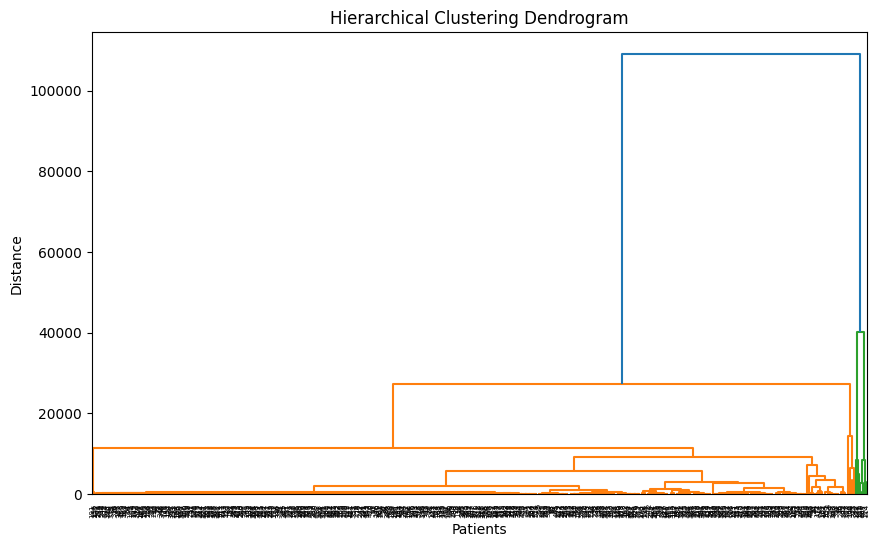

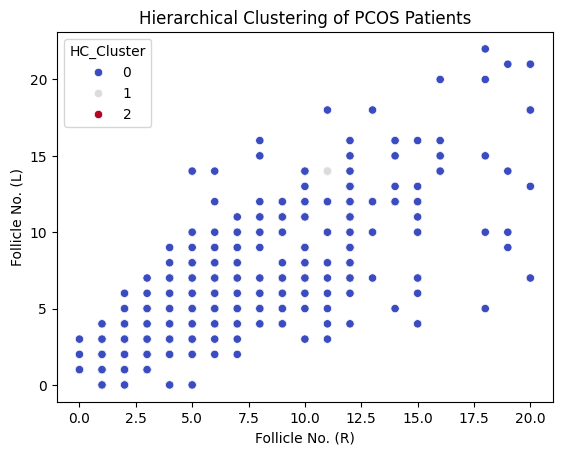

In [ ]:
## Hierarchical clustering

# Generate dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(x, method="ward"))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Patients")
plt.ylabel("Distance")
plt.show()

# Apply hierarchical clustering (adjust the number of clusters as needed)
hc = AgglomerativeClustering(n_clusters=3, linkage="ward")
data["HC_Cluster"] = hc.fit_predict(x)

# Visualize clusters
sns.scatterplot(x=data["Follicle No. (R)"], y=data["Follicle No. (L)"], hue=data["HC_Cluster"], palette="coolwarm")
plt.xlabel("Follicle No. (R)")
plt.ylabel("Follicle No. (L)")
plt.title("Hierarchical Clustering of PCOS Patients")
plt.show()

In [ ]:
## Primary Component Analysis (PCA)

# Compute covariance matrix
cov_matrix = np.cov(X_scaled.T)

# Compute eigenvalues and eigenvectors
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

# Sort eigenvectors by descending eigenvalues
sorted_indices = np.argsort(eig_values)[::-1]
eig_values = eig_values[sorted_indices]
eig_vectors = eig_vectors[:, sorted_indices]

# Set number of principal components to keep
num_pcs = 10

# Select top 'num_pcs' eigenvectors (principal components)
pc_matrix = eig_vectors[:, :num_pcs]

# Project data onto the principal components
X_pca_manual = np.dot(X_scaled, pc_matrix)

# Print results
print(f"Keeping {num_pcs} principal components")
print("Projected Data Shape:", X_pca_manual.shape)

# Splitting dataset
X_PCAtrain, X_PCAtest, y_train, y_test = train_test_split(X_pca_manual, y, test_size=0.2, random_state=42)

Keeping 10 principal components
Projected Data Shape: (541, 10)


Test set accuracy: 0.8623853211009175
Best hyperparameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'sgd'}

Best cross-validation accuracy: 90.51%
Test set accuracy: 88.07%

===== MLP PCA Classifier =====
Accuracy: 0.88
Precision: 0.88
Recall: 0.69
F1-score: 0.77
AUC: 0.95


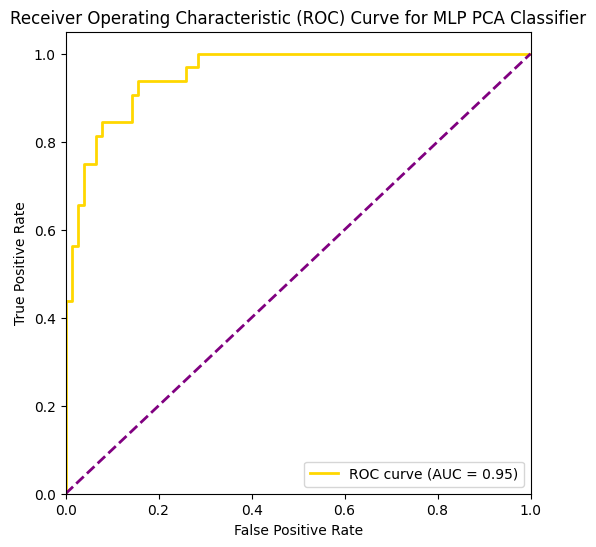

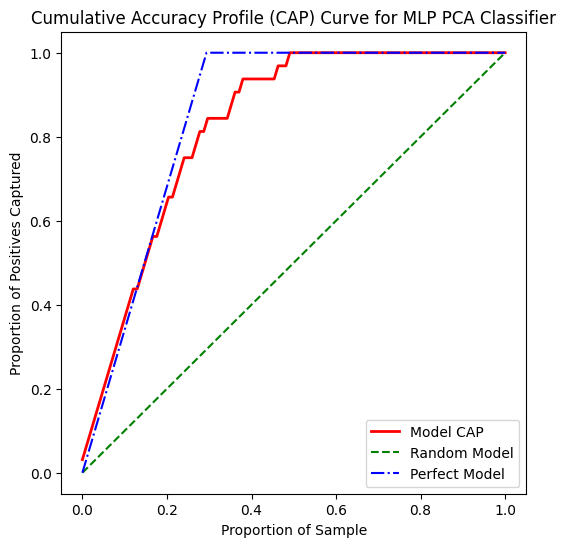

In [ ]:
# MLP using PCA Data

# Create an MLP classifier with PCA data
mlp_PCA = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=10)
mlp_PCA.fit(X_PCAtrain, y_train)

# Evaluate the model
accuracy = mlp_PCA.score(X_PCAtest, y_test)
print("Test set accuracy:", accuracy)

# Hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],  # L2 regularization term
    'learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(estimator=mlp_PCA, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_PCAtrain, y_train)

# Display best parameters
print("Best hyperparameters found:", grid_search.best_params_)
print("\nBest cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Evaluate best model
best_mlp = grid_search.best_estimator_
test_accuracy = best_mlp.score(X_PCAtest, y_test)
print("Test set accuracy: {:.2f}%".format(test_accuracy * 100))

# Calculate y_pred and y_prob using the best model
y_MLP_PCApred = best_mlp.predict(X_PCAtest) # Define y_pred using the best model from GridSearchCV
y_MLP_PCAprob = best_mlp.predict_proba(X_PCAtest)[:, 1] # Define y_prob

metrics(y_test, y_MLP_PCApred, 'MLP PCA Classifier')

# Call the ROC function
plot_roc(y_test, y_MLP_PCAprob, 'MLP PCA Classifier')

# Call the CAP function
plot_cap(y_test, y_MLP_PCAprob, 'MLP PCA Classifier')


===== Random Forest on PCA data =====
Accuracy: 0.84
Precision: 0.83
Recall: 0.59
F1-score: 0.69
Random Forest (n_estimators=10) Accuracy: 0.8624

===== Random Forest on PCA data =====
Accuracy: 0.84
Precision: 0.80
Recall: 0.62
F1-score: 0.70
Random Forest (n_estimators=15) Accuracy: 0.8624

===== Random Forest on PCA data =====
Accuracy: 0.86
Precision: 0.87
Recall: 0.62
F1-score: 0.73
Random Forest (n_estimators=20) Accuracy: 0.8624

===== Random Forest on PCA data =====
Accuracy: 0.87
Precision: 0.88
Recall: 0.66
F1-score: 0.75
Random Forest (n_estimators=25) Accuracy: 0.8624

===== Random Forest on PCA data =====
Accuracy: 0.85
Precision: 0.86
Recall: 0.59
F1-score: 0.70
Random Forest (n_estimators=30) Accuracy: 0.8624

===== Random Forest on PCA data =====
Accuracy: 0.87
Precision: 0.88
Recall: 0.66
F1-score: 0.75
Random Forest (n_estimators=50) Accuracy: 0.8624

===== Random Forest on PCA data =====
Accuracy: 0.87
Precision: 0.91
Recall: 0.62
F1-score: 0.74
Random Forest (n_est

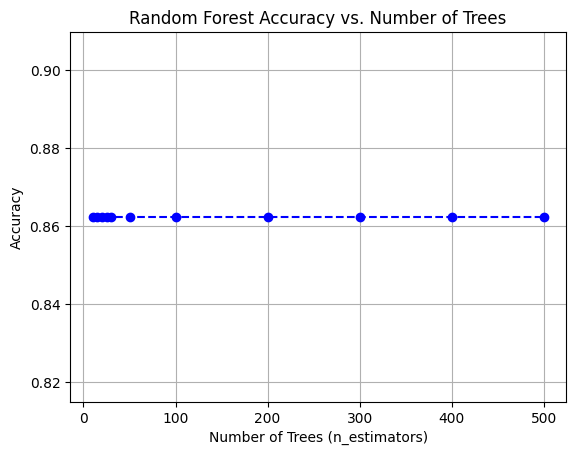

In [ ]:
## Random Forest on PCA

# Train Random Forest
rf_PCAclassifier = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_PCAtrain, y_train)
rf_y_PCApred = rf_PCAclassifier.predict(X_PCAtest)
rf_y_PCAprob = rf_PCAclassifier.predict_proba(X_PCAtest)[:, 1]

n_estimators_list = [10, 15, 20, 25, 30, 50, 100, 200, 300, 400, 500]  # Relevant range for tuning
accuracy_scores = []

# Loop through different n_estimators and store accuracy
for n_estimators in n_estimators_list:
    rf_tuned = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    accuracy = train_evaluate(rf_tuned, X_PCAtrain, X_PCAtest, y_train, y_test, "Random Forest on PCA data")
    accuracy_scores.append(accuracy)
    print(f"Random Forest (n_estimators={n_estimators}) Accuracy: {accuracy:.4f}")

# Plot Accuracy Trend
plt.plot(n_estimators_list, accuracy_scores, marker="o", linestyle="--", color="b")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs. Number of Trees")
plt.grid()
plt.show()


===== SVM =====
Accuracy: 0.88
Precision: 0.88
Recall: 0.69
F1-score: 0.77
AUC: 0.94


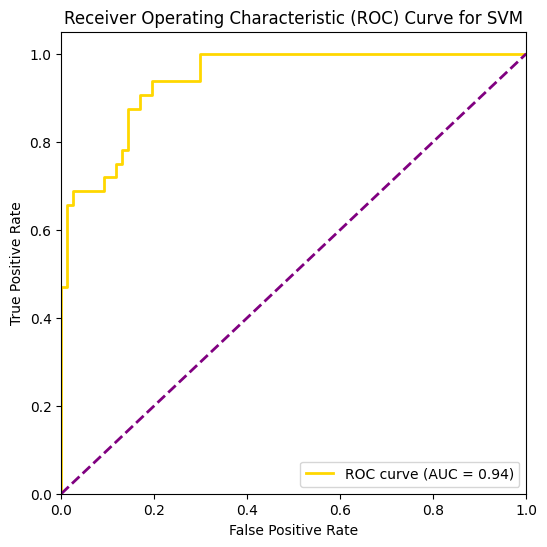

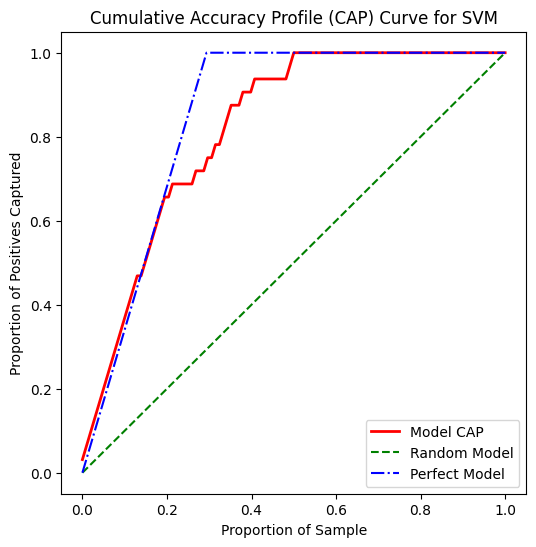

In [ ]:
#SVM using PCA data

# Train and evaluate SVM
svm_classifier = SVC(kernel="linear", probability=True, random_state=42)
train_evaluate(svm_classifier, X_PCAtrain, X_PCAtest, y_train, y_test, "SVM")

# Predictions
svm_PCA_y_pred = svm_classifier.predict(X_PCAtest)
svm_PCA_y_prob = svm_classifier.predict_proba(X_PCAtest)[:, 1]

# ROC & CAP Evaluation
plot_roc(y_test, svm_PCA_y_prob, "SVM")
plot_cap(y_test, svm_PCA_y_prob, "SVM")

In [ ]:
# Table 1: Most Accurate Version of Each Model on Full Data
full_model_metrics = {
    "Random Forest (Full)": {"Accuracy": 0.92, "Precision": 0.93, "Recall": 0.78, "F1-score": 0.85, "AUC": 0.95},
    "Decision Tree (Full)": {"Accuracy": 0.83, "Precision": 0.71, "Recall": 0.75, "F1-score": 0.73, "AUC": 0.94},
    "KNN (Full)": {"Accuracy": 0.66, "Precision": 0.39, "Recall": 0.28, "F1-score": 0.33, "AUC": 0.56},
    "MLP Classifier (Full)": {"Accuracy": 0.90, "Precision": 0.84, "Recall": 0.81, "F1-score": 0.83, "AUC": 0.95},
    "Naive Bayes (Full)": {"Accuracy": 0.78, "Precision": 0.59, "Recall": 0.84, "F1-score": 0.69, "AUC": 0.84},
    "SVM (Full)": {"Accuracy": 0.84, "Precision": 0.80, "Recall": 0.62, "F1-score": 0.70, "AUC": 0.84}
}

# Convert dictionary to Pandas DataFrame
full_model_df = pd.DataFrame.from_dict(full_model_metrics, orient="index")

# Display results
print("Table 1: Most Accurate Version of Each Model on Full Data")
print(full_model_df)

# Table 2: Comparing Full vs. PCA-Trained Versions of Top Models
pca_model_metrics = {
    "Random Forest (Full)": {"Accuracy": 0.87, "Precision": 0.91, "Recall": 0.62, "F1-score": 0.74, "AUC": 0.94},
    "Random Forest (PCA)": {"Accuracy": 0.84, "Precision": 0.83, "Recall": 0.59, "F1-score": 0.69, "AUC": 0.91},
    "MLP Classifier (Full)": {"Accuracy": 0.88, "Precision": 0.91, "Recall": 0.66, "F1-score": 0.76, "AUC": 0.94},
    "MLP Classifier (PCA)": {"Accuracy": 0.88, "Precision": 0.88, "Recall": 0.69, "F1-score": 0.77, "AUC": 0.95},
    "SVM (Full)": {"Accuracy": 0.84, "Precision": 0.80, "Recall": 0.62, "F1-score": 0.70, "AUC": 0.84},
    "SVM (PCA)": {"Accuracy": 0.88, "Precision": 0.88, "Recall": 0.69, "F1-score": 0.77, "AUC": 0.94},
}

# Convert dictionary to Pandas DataFrame
pca_model_df = pd.DataFrame.from_dict(pca_model_metrics, orient="index")

# Display results
print("\nTable 2: Comparison of Top Models (Full vs. PCA-Trained)")
print(pca_model_df)

Table 1: Most Accurate Version of Each Model on Full Data
                       Accuracy  Precision  Recall  F1-score   AUC
Random Forest (Full)       0.87       0.91    0.62      0.74  0.94
Decision Tree (Full)       0.83       0.71    0.75      0.73  0.94
KNN (Full)                 0.66       0.39    0.28      0.33  0.56
MLP Classifier (Full)      0.88       0.91    0.66      0.76  0.94
Naive Bayes (Full)         0.78       0.59    0.84      0.69  0.84
SVM (Full)                 0.84       0.80    0.62      0.70  0.84

Table 2: Comparison of Top Models (Full vs. PCA-Trained)
                       Accuracy  Precision  Recall  F1-score   AUC
Random Forest (Full)       0.87       0.91    0.62      0.74  0.94
Random Forest (PCA)        0.84       0.83    0.59      0.69  0.91
MLP Classifier (Full)      0.88       0.91    0.66      0.76  0.94
MLP Classifier (PCA)       0.88       0.88    0.69      0.77  0.95
SVM (Full)                 0.84       0.80    0.62      0.70  0.84
SVM (PCA)    

In [59]:
# Import KFold Library
from sklearn.model_selection import KFold

models = [
    ("MLP", MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='sgd', alpha=0.0001, learning_rate_init=0.001, max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(max_depth=10, min_samples_split=2, random_state=42)),
    ("KNN", KNeighborsClassifier())
]

# Set up k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
results = {name: [] for name, _ in models}

# Convert to numpy array
 #x = x.to_numpy()
 #y = y.to_numpy()

# Cross-validation loop
def Cross_Validation(x, y, models, kf):
  for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

     # Scale features using training set only
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        precision = precision_score(y_test, y_pred)
        results[name].append(precision)

Cross_Validation(x, y, models, kf)

# Print results
df_results = pd.DataFrame(results)
print(df_results)

        MLP  Random Forest  Decision Tree       KNN
0  0.785714       0.875000       0.705882  0.833333
1  0.911765       0.937500       0.861111  0.843750
2  0.764706       0.838710       0.750000  0.862069
3  0.857143       0.928571       0.800000  0.896552
4  0.861111       0.964286       0.710526  0.928571


In [60]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Reshape the data
performance_scores = np.array(df_results.values.flatten())
models = np.array(df_results.columns.tolist() * len(df_results))

# Apply post-hoc Tukey test
tukey_result = pairwise_tukeyhsd(performance_scores, models, alpha=0.05)

# Print the result
print(tukey_result)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Decision Tree           KNN   0.1074 0.0317  0.0081 0.2066   True
Decision Tree           MLP   0.0706 0.2165 -0.0286 0.1698  False
Decision Tree Random Forest   0.1433 0.0039  0.0441 0.2425   True
          KNN           MLP  -0.0368 0.7177  -0.136 0.0625  False
          KNN Random Forest    0.036  0.731 -0.0633 0.1352  False
          MLP Random Forest   0.0727 0.1961 -0.0265  0.172  False
-----------------------------------------------------------------


In [57]:
# Import Libraries
from sklearn.model_selection import KFold

# Define models with best-tuned parameters
models = [
    ("MLP", MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='sgd', alpha=0.0001, learning_rate_init=0.001, max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(max_depth=10, min_samples_split=2, random_state=42)),
    ("KNN", KNeighborsClassifier())
]

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
results = {name: {"Precision": [], "Recall": [], "0.3 Threshold Recall": []} for name, _ in models}

# Convert to numpy arrays
#x = x.to_numpy()
#y = y.to_numpy()

# Cross-validation loop
def Cross_Validation(x, y, models, kf, threshold=0.3):  # Lower threshold for recall prioritization
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Scale features using training set only
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))

            # Apply threshold adjustment for recall prioritization
            y_adjusted_pred = (y_prob >= threshold).astype(int)

            # Compute metrics
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            adjusted_recall = recall_score(y_test, y_adjusted_pred)

            # Store results
            results[name]["Precision"].append(precision)
            results[name]["Recall"].append(recall)
            results[name]["0.3 Threshold Recall"].append(adjusted_recall)

Cross_Validation(x, y, models, kf)

# Convert results to DataFrame and print
df_results = pd.DataFrame({name: {metric: np.mean(values) for metric, values in metrics.items()} for name, metrics in results.items()})
print(df_results)

                           MLP  Random Forest  Decision Tree       KNN
Precision             0.836088       0.908813       0.765504  0.872855
Recall                0.789790       0.735912       0.757568  0.701640
0.3 Threshold Recall  0.857706       0.931134       0.757568  0.784373


In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Reshape the data
performance_scores = np.array(df_results.values.flatten())
models = np.array(df_results.columns.tolist() * len(df_results))

# Apply post-hoc Tukey test
tukey_result = pairwise_tukeyhsd(performance_scores, models, alpha=0.05)

# Print the result
print(tukey_result)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Decision Tree           KNN   0.0261 0.9674 -0.1587 0.2108  False
Decision Tree           MLP   0.0676 0.6591 -0.1171 0.2524  False
Decision Tree Random Forest   0.0984 0.3805 -0.0864 0.2832  False
          KNN           MLP   0.0416 0.8863 -0.1432 0.2263  False
          KNN Random Forest   0.0723 0.6136 -0.1124 0.2571  False
          MLP Random Forest   0.0308 0.9485  -0.154 0.2155  False
-----------------------------------------------------------------


Test set accuracy: 0.8623853211009175
Best hyperparameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'sgd'}

Best cross-validation accuracy: 86.21%
Test set accuracy: 88.07%
Adjusted Recall with threshold 0.3: 0.81

===== Adjusted MLP PCA Classifier =====
Accuracy: 0.90
Precision: 0.84
Recall: 0.81
F1-score: 0.83
AUC: 0.95


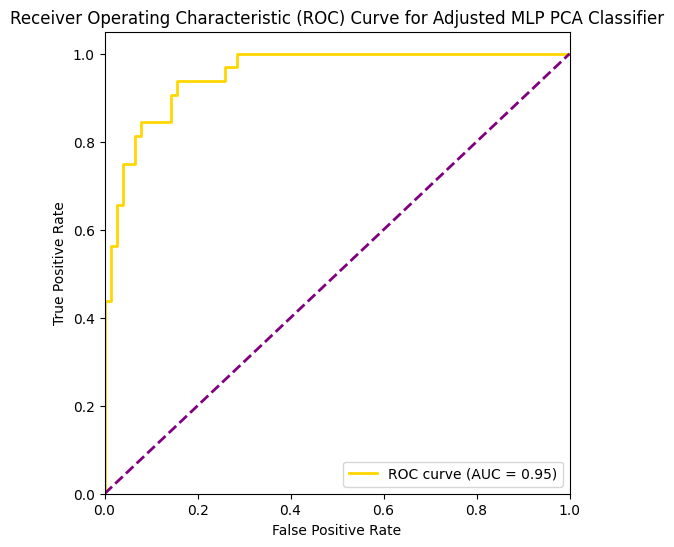

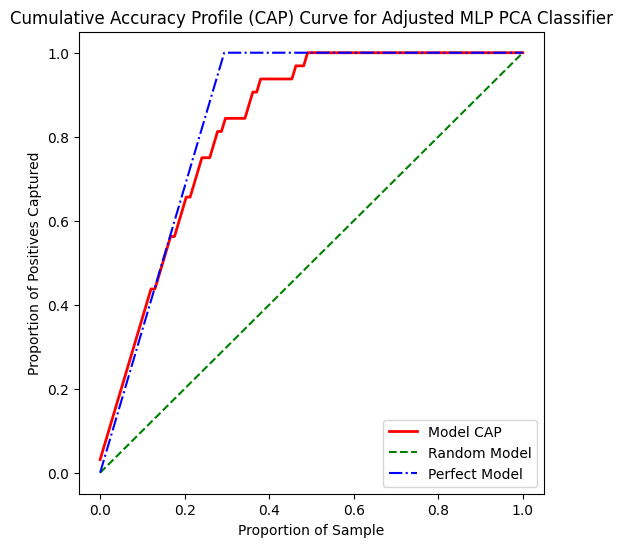

In [ ]:
## MLP prioritizing Reduction of Type II Error

# Create an MLP classifier with PCA data
mlp_PCA_recall = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=1000, random_state=10)
mlp_PCA_recall.fit(X_PCAtrain, y_train)

# Evaluate the model
accuracy = mlp_PCA_recall.score(X_PCAtest, y_test)
print("Test set accuracy:", accuracy)

# Hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],  # L2 regularization term
    'learning_rate_init': [0.001, 0.01]

}

grid_search = GridSearchCV(estimator=mlp_PCA_recall, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search.fit(X_PCAtrain, y_train)

# Display best parameters
print("Best hyperparameters found:", grid_search.best_params_)
print("\nBest cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Evaluate best model
best_mlp_recall = grid_search.best_estimator_
test_recall = best_mlp_recall.score(X_PCAtest, y_test)
print("Test set accuracy: {:.2f}%".format(test_accuracy * 100))

# Calculate y_pred and y_prob using the best model
y_MLP_PCA_recall_pred = best_mlp_recall.predict(X_PCAtest) # Define y_pred using the best model from GridSearchCV
y_MLP_PCA_recall_prob = best_mlp_recall.predict_proba(X_PCAtest)[:, 1] # Define y_prob

# Lower threshold to reduce false negatives
threshold = 0.3

# Apply threshold to predicted probabilities
y_adjusted_pred = (y_MLP_PCA_recall_prob >= threshold).astype(int)

# Compute recall score after threshold adjustment
new_recall = recall_score(y_test, y_adjusted_pred)
print(f"Adjusted Recall with threshold {threshold}: {new_recall:.2f}")

metrics(y_test, y_adjusted_pred, 'Adjusted MLP PCA Classifier')

# Call the ROC function
plot_roc(y_test, y_MLP_PCA_recall_prob, 'Adjusted MLP PCA Classifier')

# Call the CAP function
plot_cap(y_test, y_MLP_PCA_recall_prob, 'Adjusted MLP PCA Classifier')